# Линейная регрессия

## Импорт модулей

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np

## Константы

In [2]:
TRAIN_PATH = "./data/train.csv"
TEST_PATH = "./data/test.csv"
RANDOM_STATE = 777

## Загрузка данных

In [3]:
df_train = pd.read_csv(TRAIN_PATH, index_col="id")

print("Train DataFrame")
df_train.head()

Train DataFrame


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [4]:
df_test = pd.read_csv(TEST_PATH, index_col="id")

print("Test DataFrame Features")
df_test.head()

Test DataFrame Features


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
id,,,,,,,,,,,,,,,
360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


Можно видеть, что test.csv не содержит целевую переменную, дальнейшую работу будем проводить только с train.csv.

## Исследовательский анализ данных

In [5]:
def calculate_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats

In [6]:
# Результаты EDA
train_stats = calculate_stats(df_train)

print("Train DataFrame Statistics:")
train_stats

Train DataFrame Statistics:


,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
store_sales(in millions),0.0,0.51,22.92,6.34,5.78,10.94,2.32,11.04,3.72,8.40
unit_sales(in millions),0.0,1.00,6.00,3.04,3.00,0.62,2.00,4.00,3.00,4.00
total_children,0.0,0.00,5.00,2.46,2.00,2.22,0.00,4.00,1.00,4.00
num_children_at_home,0.0,0.00,5.00,0.69,0.00,1.48,0.00,3.00,0.00,1.00
avg_cars_at home(approx).1,0.0,0.00,4.00,2.20,2.00,1.18,1.00,4.00,1.00,3.00
gross_weight,0.0,6.00,21.90,13.82,13.60,21.30,7.71,20.30,9.71,17.70
recyclable_package,0.0,0.00,1.00,0.57,1.00,0.25,0.00,1.00,0.00,1.00
low_fat,0.0,0.00,1.00,0.33,0.00,0.22,0.00,1.00,0.00,1.00
units_per_case,0.0,1.00,36.00,18.97,20.00,104.30,5.00,33.00,10.00,28.00
store_sqft,0.0,20319.00,39696.00,28180.33,27694.00,35627457.71,21215.00,38382.00,23593.00,33858.00


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float64
 13  prepared_food      

Данные не содержат пропущенных значений и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

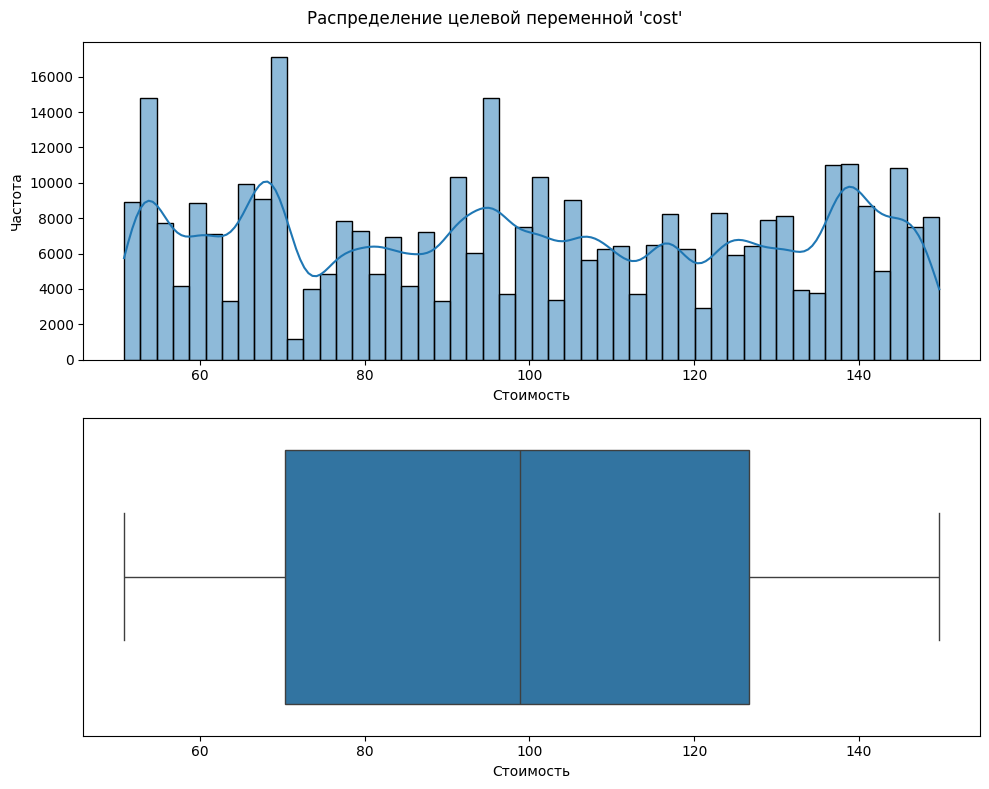

In [8]:
# Визуализация распределения "cost"
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_train["cost"], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Стоимость")
ax[0].set_ylabel("Частота")

sns.boxplot(df_train["cost"], orient="h", ax=ax[1])
ax[1].set_xlabel("Стоимость")
ax[1].set_yticks([])

plt.suptitle("Распределение целевой переменной 'cost'")
plt.tight_layout()
plt.show()

Целевая переменная имеет распределение, напоминающее равномерное и не содержит заметных выбросов.

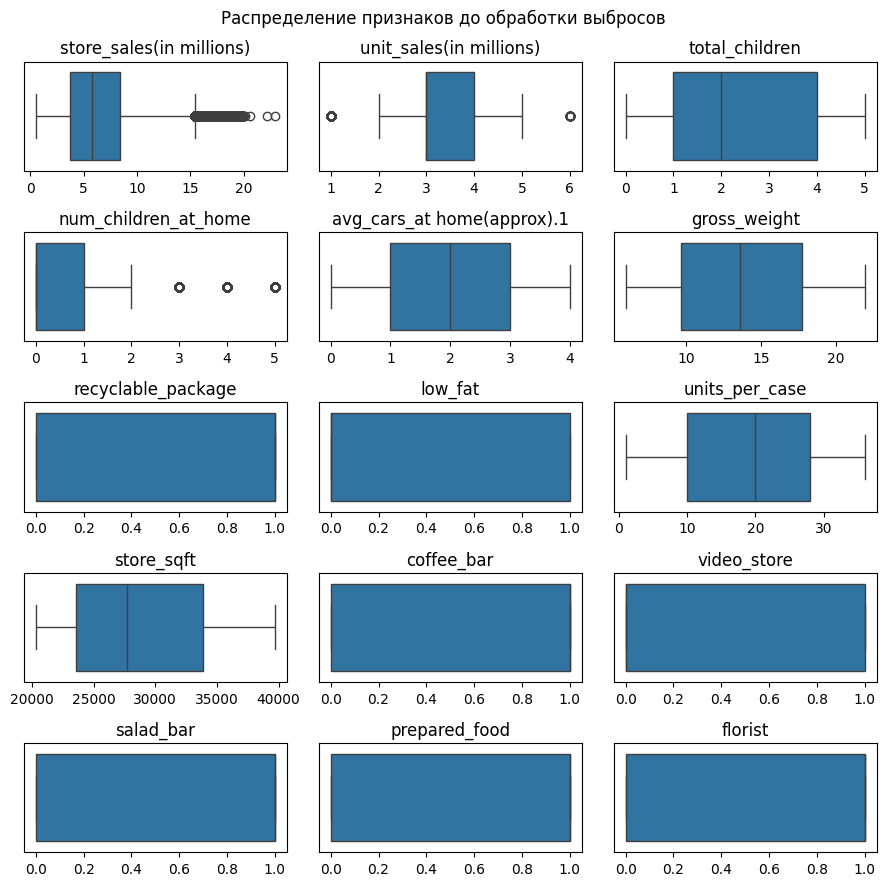

In [9]:
# Отображение признаков до обработки выбросов
columns = [col for col in df_train.columns if col != "cost"]

fig, ax = plt.subplots(5, 3, figsize=(9, 9))

for i, col in enumerate(columns):
    row_idx, col_idx = divmod(i, 3)
    sns.boxplot(df_train[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение признаков до обработки выбросов")
plt.tight_layout()
plt.show()

Видно, что признаки store_sales(in millions), unit_sales(in millions), num_children_at_home имеют выбросы. Исправим их методом межквартильного размаха.

In [10]:
# Функция для обработки выбросов
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df


df_train = remove_outliers(
    df_train,
    ["store_sales(in millions)", "unit_sales(in millions)", "num_children_at_home"],
)

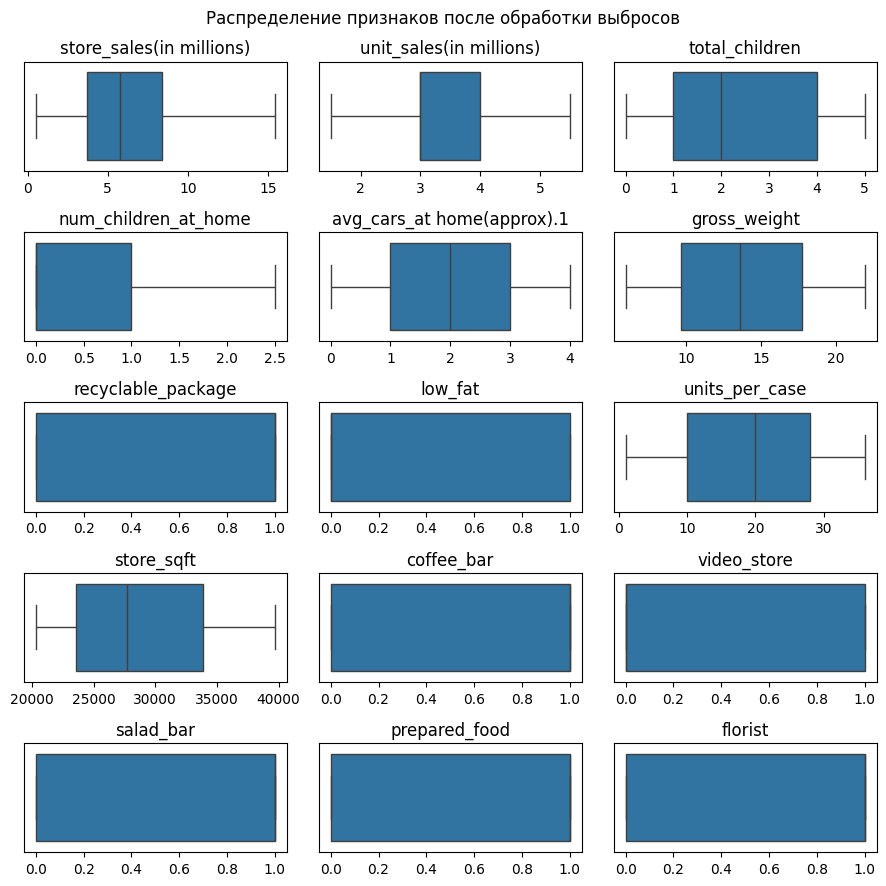

In [11]:
# Отображение признаков после обработки выбросов
columns = [col for col in df_train.columns if col != "cost"]

fig, ax = plt.subplots(5, 3, figsize=(9, 9))

for i, col in enumerate(columns):
    row_idx, col_idx = divmod(i, 3)
    sns.boxplot(df_train[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

plt.suptitle("Распределение признаков после обработки выбросов")
plt.tight_layout()
plt.show()

После обработки выбросы отсутствуют.

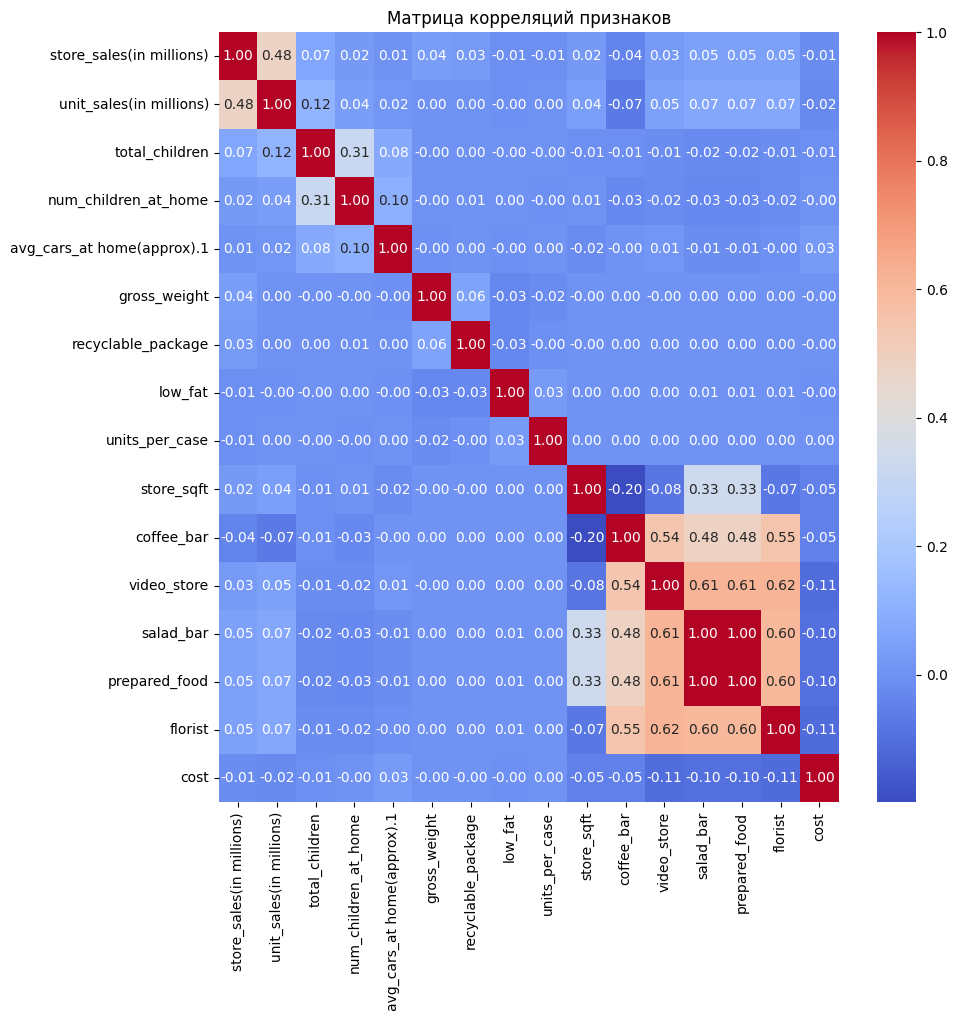

In [12]:
# Матрица корреляций
plt.figure(figsize=(10, 10))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций признаков")
plt.show()

Часть признаков имеет среднюю степень скоррелированности: coffee_bar, video_store, salad_bar, prepared_food, florist. Остальные признаки слабо скоррелированны, оставим набор признаков без изменения.

In [13]:
# Разделение данных на обучающую и тестовую выборки
X = df_train.drop(columns=["cost"])
y = df_train["cost"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Обучение моделей

In [14]:
# Модель OLS из statsmodels
# Добавляем константу
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_sm).fit()
y_pred_ols = ols_model.predict(X_test_sm)

# Модель LinearRegression из scikit-learn
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

## Оценка качества моделей

In [15]:
# Модель OLS из statsmodels
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mse_ols = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)

# Модель LinearRegression из scikit-learn
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": ["MAE", "MSE", "RMSE"],
        "OLS (statsmodels)": [
            *map(lambda x: round(x, 2), [mae_ols, mse_ols, rmse_ols])
        ],
        "LinearRegression (sklearn)": [
            *map(lambda x: round(x, 2), [mae_lr, mse_lr, rmse_lr])
        ],
    }
)

quality_comparison

,Metrics,OLS (statsmodels),LinearRegression (sklearn)
0,MAE,25.52,25.52
1,MSE,877.90,877.90
2,RMSE,29.63,29.63


Модели показывают идентичные результаты, выбираем LinearRegression (sklearn).

## Важность признаков

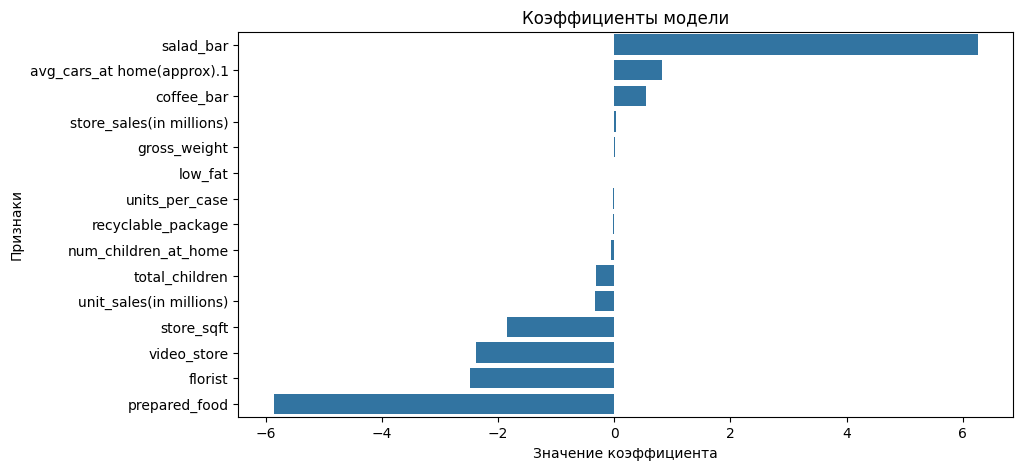

In [16]:
# Получение коэффициентов линейной регрессии
coefficients = pd.DataFrame(
    {"feature": X.columns, "coeff": lr_model.coef_}
).sort_values(by="coeff", ascending=False)

# Визуализация коэффициентов
plt.figure(figsize=(10, 5))
sns.barplot(coefficients, x="coeff", y="feature")
plt.xlabel("Значение коэффициента")
plt.ylabel("Признаки")
plt.title("Коэффициенты модели")
plt.show()

Наибольшее влияние на предсказание модели оказывают такие признаки, как salad_bar, prepared_food, florist, video_store, store_sqft.